In [80]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [81]:
# !apt-get install tree
# #clear_output()
# # create new folders
# !mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
# !tree -d

In [82]:
def load_data(dir_path, img_size=(100,100)):
    """
    بارگیری تصاویر تغییر اندازه داده شده به صورت آرایه‌های np در فضای کاری
    
    آرگومان‌ها:
    - dir_path (str): مسیر پوشه حاوی تصاویر.
    - img_size (tuple): اندازه مورد نظر برای تغییر اندازه تصاویر. پیش‌فرض (100، 100) است.
    
    برگرداندن:
    - X (np.array): آرایه حاوی تصاویر تغییر اندازه شده.
    - y (np.array): آرایه حاوی برچسب‌های متناظر با تصاویر.
    - labels (dict): یک دیکشنری حاوی شاخص‌های برچسب و نام کلاس‌های متناظر با آنها.
    """
    X = []
    y = []
    i = 0
    labels = dict()
    # حلقه بر روی دایرکتوری‌ها
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            # حلقه بر روی فایل‌ها داخل هر دایرکتوری
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    # تغییر اندازه تصویر به اندازه مورد نظر
                    img = cv2.resize(img, img_size)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    این تابع ماتریس اشتباهات را چاپ و رسم می‌کند.
    می‌توانید با تنظیم `normalize=True`، نرمال‌سازی را اعمال کنید.
    
    آرگومان‌ها:
    - cm (np.array): ماتریس اشتباهات برای رسم.
    - classes (list): لیست نام‌های کلاس‌ها.
    - normalize (bool): پرچمی که نشان می‌دهد آیا باید ماتریس را نرمال کند یا خیر. پیش‌فرض False است.
    - title (str): عنوان نمودار. پیش‌فرض 'ماتریس اشتباهات' است.
    - cmap (plt.cm): نقشه رنگی برای نمایش. پیش‌فرض plt.cm.Blues است.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [83]:
TRAIN_DIR = 'TRAIN/'  # مسیر دایرکتوری حاوی داده‌های آموزش
TEST_DIR = 'TEST/'    # مسیر دایرکتوری حاوی داده‌های تست
VAL_DIR = 'VAL/'      # مسیر دایرکتوری حاوی داده‌های اعتبارسنجی
IMG_SIZE = (224,224)  # اندازه تصاویر برای تغییر اندازه


# استفاده از تابع تعریف شده برای بارگیری داده‌های تصویری به فضای کاری
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)  # بارگیری داده‌های آموزش
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)          # بارگیری داده‌های تست
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)             # بارگیری داده‌های اعتبارسنجی


100%|██████████| 2/2 [00:00<00:00,  2.98it/s]
<ipython-input-82-59831cb31691>:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



253 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


253 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 10.16it/s]


66 images loaded from VAL/ directory.


In [84]:
y = dict()  # ایجاد یک دیکشنری جهت ذخیره‌سازی تعداد داده‌های هر کلاس
y[0] = []   # لیستی برای تعداد داده‌های کلاس ۰
y[1] = []   # لیستی برای تعداد داده‌های کلاس ۱

# حلقه برای محاسبه تعداد داده‌های هر کلاس در هر مجموعه
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))  # محاسبه تعداد داده‌های کلاس ۰ و اضافه کردن به لیست
    y[1].append(np.sum(set_name == 1))  # محاسبه تعداد داده‌های کلاس ۱ و اضافه کردن به لیست


# تعریف نمودار میله‌ای برای نمایش تعداد داده‌های هر کلاس در هر مجموعه
trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],  # محور افقی: نام مجموعه‌ها
    y=y[0],  # محور عمودی: تعداد داده‌های کلاس ۰
    name='No',  # نام کلاس
    marker=dict(color='#33cc33'),  # رنگ میله‌ها برای کلاس ۰
    opacity=0.7  # شفافیت میله‌ها
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],  # محور افقی: نام مجموعه‌ها
    y=y[1],  # محور عمودی: تعداد داده‌های کلاس ۱
    name='Yes',  # نام کلاس
    marker=dict(color='#ff3300'),  # رنگ میله‌ها برای کلاس ۱
    opacity=0.7  # شفافیت میله‌ها
)
data = [trace0, trace1]  # داده‌هایی که در نمودار استفاده می‌شود
layout = go.Layout(
    title='Count of classes in each set',  # عنوان نمودار
    xaxis={'title': 'Set'},  # عنوان محور افقی
    yaxis={'title': 'Count'}  # عنوان محور عمودی
)
fig = go.Figure(data, layout)  # ایجاد شیء نمودار
iplot(fig)  # نمایش نمودار


In [85]:
def plot_samples(X, y, labels_dict, n=50):
    """
    ساخت یک شبکه نمودار برای تعداد تصاویر موردنظر (n) از مجموعه مشخص شده
    """
    # حلقه برای ساخت شبکه نمودار برای هر کلاس
    for index in range(len(labels_dict)):
        # انتخاب تصاویر مربوط به هر کلاس
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        # ساخت شبکه نمودار
        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        # عنوان شبکه نمودار با نام کلاس متناظر
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()


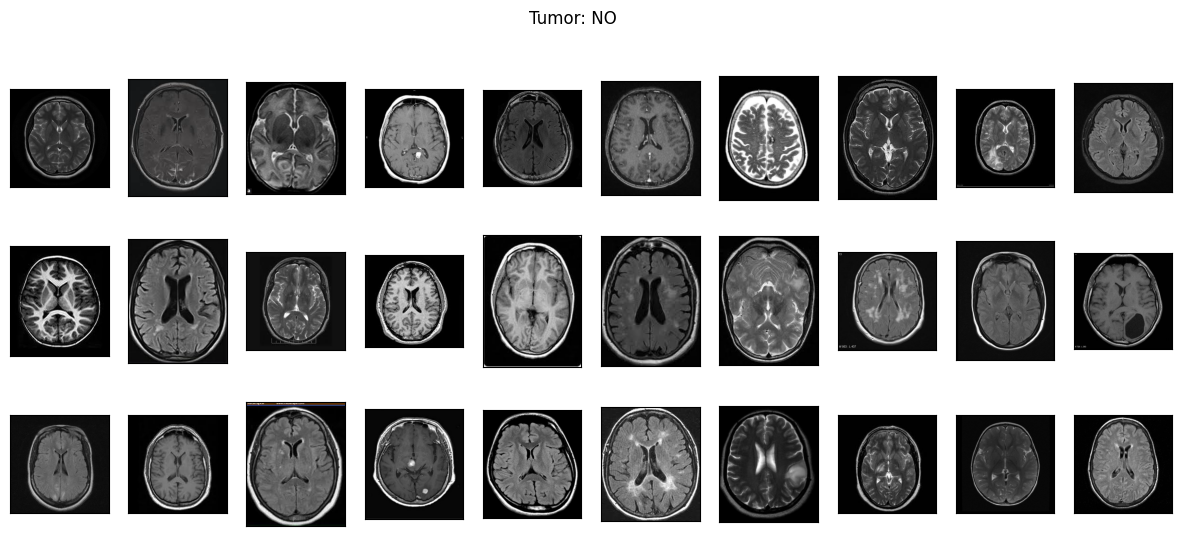

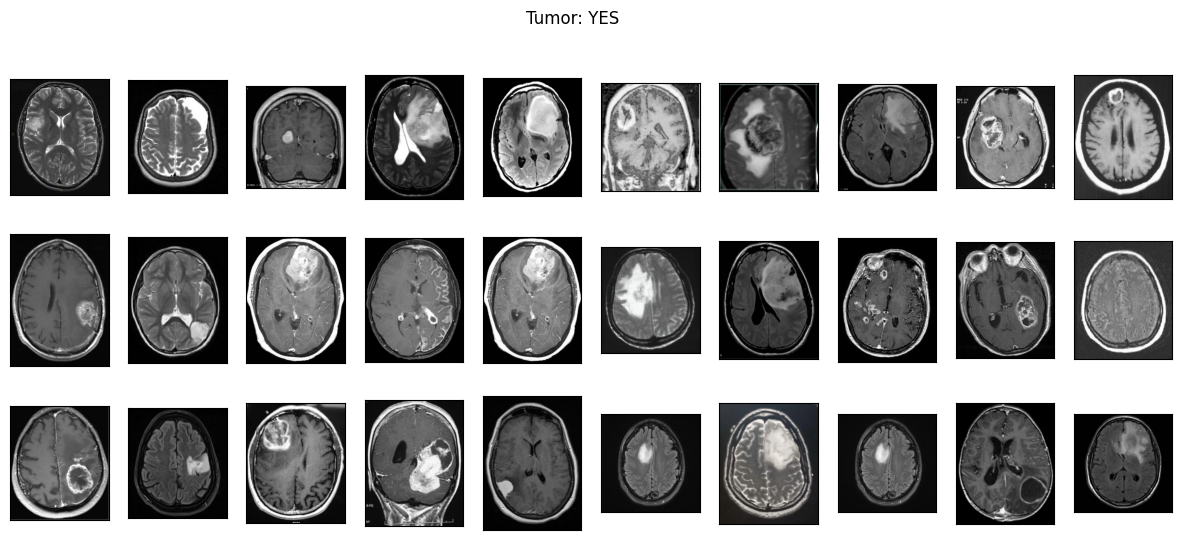

In [86]:
plot_samples(X_train, y_train, labels, 30)

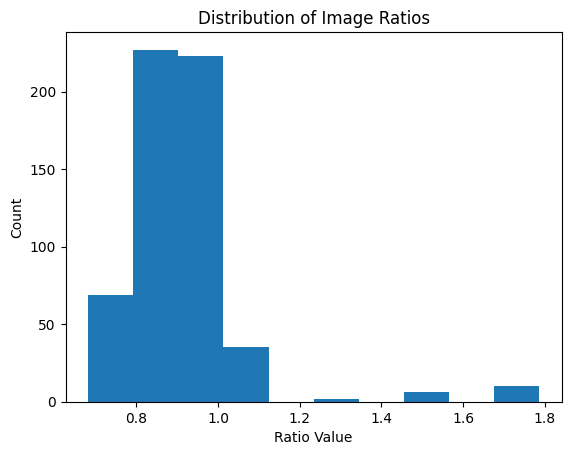

In [87]:
# ایجاد یک لیست جهت ذخیره نسبت اندازه‌های تصاویر
RATIO_LIST = []
# حلقه برای محاسبه نسبت اندازه‌های تصاویر در هر مجموعه داده
for set in (X_train, X_test, X_val):
    for img in set:
        # محاسبه نسبت عرض به ارتفاع برای هر تصویر و اضافه کردن به لیست
        RATIO_LIST.append(img.shape[1] / img.shape[0])

# رسم هیستوگرام توزیع نسبت‌های تصاویر
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [88]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    یافتن نقاط انتهایی تصویر و برش مستطیلی از آنها
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # تبدیل تصویر به مقیاس خاکستری
        gray = cv2.GaussianBlur(gray, (5, 5), 0)  # اعمال فیلتر گوسی برای کاهش نویز

        # آستانه‌ای کردن تصویر، سپس انجام سری عملیات فرسایش و تورم برای حذف نواحی کوچک نویزی
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # یافتن کنتورها در تصویر آستانه‌ای، سپس گرفتن بزرگترین کنتور
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # یافتن نقاط انتهایی
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        # برش تصویر با افزودن مقدار پیکسل‌ها
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)


In [89]:
img = cv2.imread('/content/TRAIN/YES/Y108.jpg')  # بارگیری تصویر
img = cv2.resize(  # تغییر اندازه تصویر
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # تبدیل تصویر به مقیاس خاکستری
gray = cv2.GaussianBlur(gray, (5, 5), 0)  # اعمال فیلتر گوسی برای کاهش نویز

# آستانه‌ای کردن تصویر، سپس انجام سری عملیات فرسایش و تورم برای حذف نواحی کوچک نویزی
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# یافتن کنتورها در تصویر آستانه‌ای، سپس گرفتن بزرگترین کنتور
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# یافتن نقاط انتهایی
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# افزودن کنتور بر روی تصویر
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# افزودن نقاط انتهایی
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# برش
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()


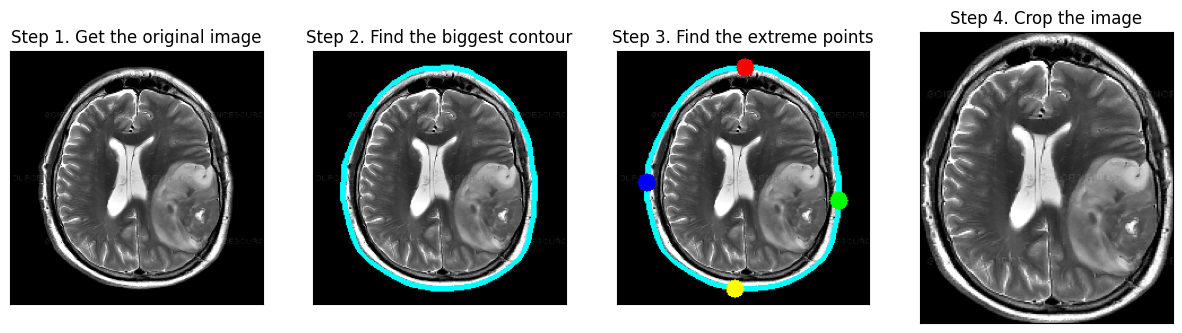

In [90]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [91]:
# برای هر مجموعه داده، این عملیات اعمال می‌شود
X_train_crop = crop_imgs(set_name=X_train)  # برش تصاویر برای مجموعه آموزشی
X_val_crop = crop_imgs(set_name=X_val)  # برش تصاویر برای مجموعه اعتبارسنجی
X_test_crop = crop_imgs(set_name=X_test)  # برش تصاویر برای مجموعه آزمون


<ipython-input-88-65876982ba26>:31: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



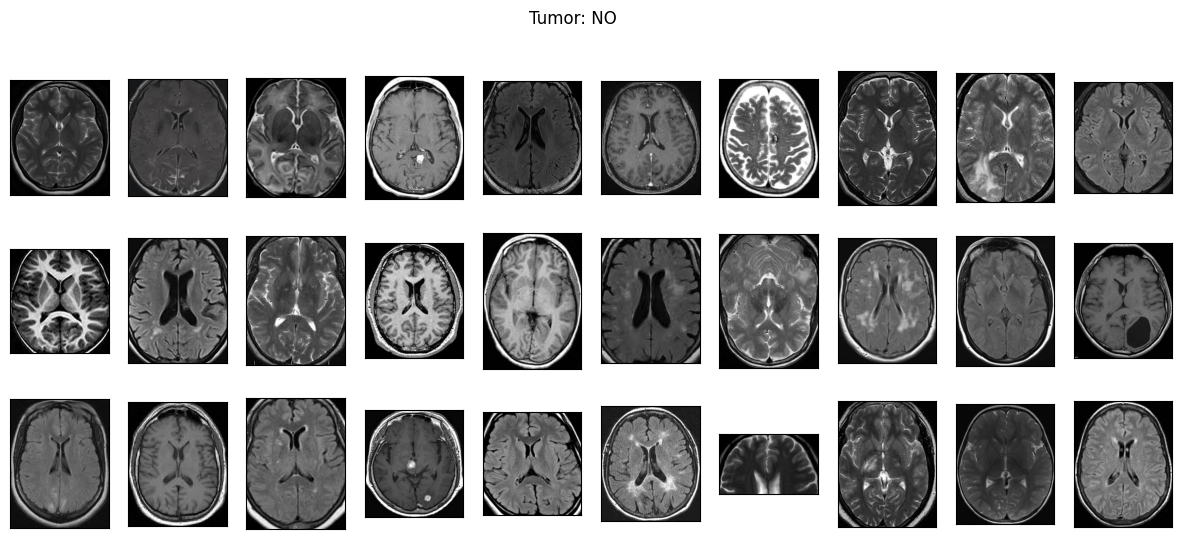

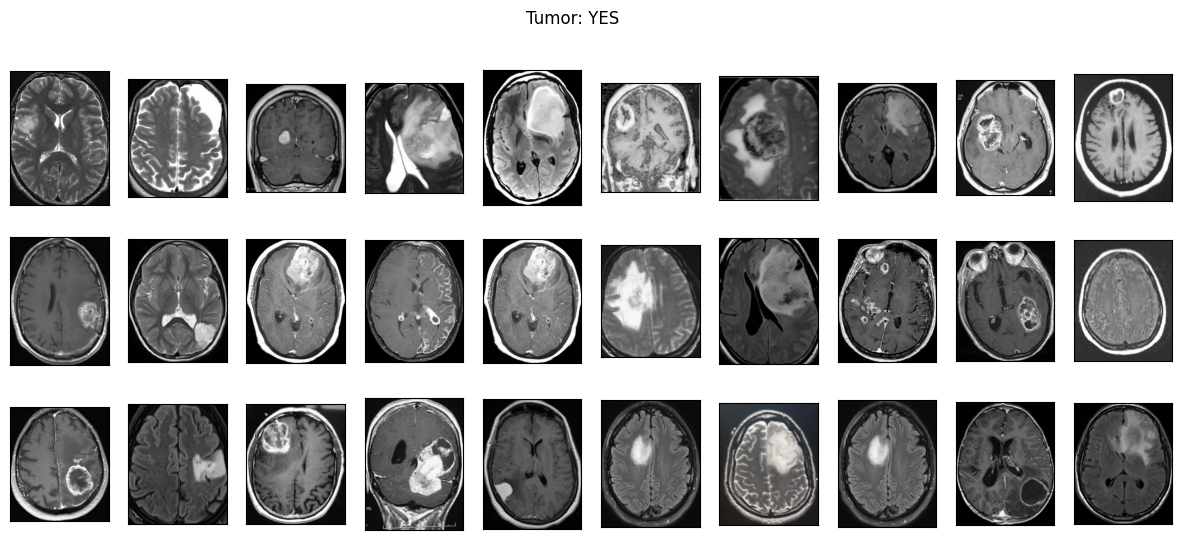

In [92]:
plot_samples(X_train_crop, y_train, labels, 30)

In [93]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    # برای هر تصویر در مجموعه داده
    for (img, imclass) in zip(x_set, y_set):
        # اگر تصویر به کلاس ۰ تعلق داشت
        if imclass == 0:
            # ذخیره تصویر در پوشه مربوط به کلاس NO با نام شماره‌ی توالی
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            # ذخیره تصویر در پوشه مربوط به کلاس YES با نام شماره‌ی توالی
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1


In [94]:
# ایجاد پوشه‌های جدید برای تصاویر برش خورده
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

# ذخیره تصاویر جدید در پوشه‌های مربوطه
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')  # ذخیره تصاویر آموزشی
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')  # ذخیره تصاویر اعتبارسنجی
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')  # ذخیره تصاویر آزمون


mkdir: cannot create directory ‘TRAIN_CROP’: File exists
mkdir: cannot create directory ‘TEST_CROP’: File exists
mkdir: cannot create directory ‘VAL_CROP’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/YES’: File exists
mkdir: cannot create directory ‘TRAIN_CROP/NO’: File exists
mkdir: cannot create directory ‘TEST_CROP/YES’: File exists
mkdir: cannot create directory ‘TEST_CROP/NO’: File exists
mkdir: cannot create directory ‘VAL_CROP/YES’: File exists
mkdir: cannot create directory ‘VAL_CROP/NO’: File exists


In [95]:
def preprocess_imgs(set_name, img_size):
    """
    تغییر اندازه و اعمال پیش‌پردازش VGG-15
    """
    set_new = []
    for img in set_name:
        # تغییر اندازه تصویر
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        # اعمال پیش‌پردازش VGG-15
        set_new.append(preprocess_input(img))
    return np.array(set_new)


In [96]:
# اعمال پیش‌پردازش بر روی تصاویر برش خورده برای هر مجموعه داده
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)  # پیش‌پردازش برای مجموعه آموزش
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)  # پیش‌پردازش برای مجموعه آزمون
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)  # پیش‌پردازش برای مجموعه اعتبارسنجی


In [97]:
# تعیین پارامترهایی که می‌خواهیم به صورت تصادفی تغییر دهیم
demo_datagen = ImageDataGenerator(
    rotation_range=15,  # محدوده چرخش تصاویر
    width_shift_range=0.05,  # محدوده تغییر عرض تصاویر
    height_shift_range=0.05,  # محدوده تغییر ارتفاع تصاویر
    rescale=1./255,  # مقیاس داده‌ها
    shear_range=0.05,  # مقدار شیری تصاویر
    brightness_range=[0.1, 1.5],  # محدوده روشنایی تصاویر
    horizontal_flip=True,  # چرخش افقی تصاویر به صورت تصادفی
    vertical_flip=True  # چرخش عمودی تصاویر به صورت تصادفی
)


In [99]:
# ایجاد یک پوشه برای ذخیره تصاویر پیش‌پردازش شده
# اگر پوشه وجود داشته باشد، پوشه موجود استفاده می‌شود؛ در غیر این صورت پوشه ایجاد می‌شود
os.makedirs('preview', exist_ok=True)

# گرفتن یک تصویر از مجموعه آموزشی به عنوان نمونه
x = X_train_crop[0]
x = x.reshape((1,) + x.shape)

# تولید تصاویر جدید با استفاده از پارامترهای تعیین شده
i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    # محدود کردن تعداد تصاویر تولید شده به 20 تصویر
    if i > 20:
        break


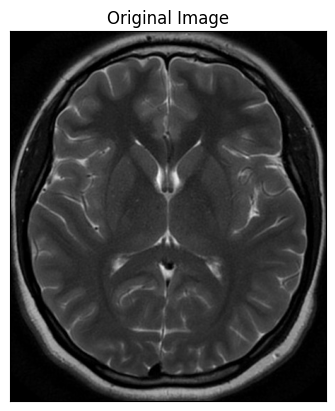

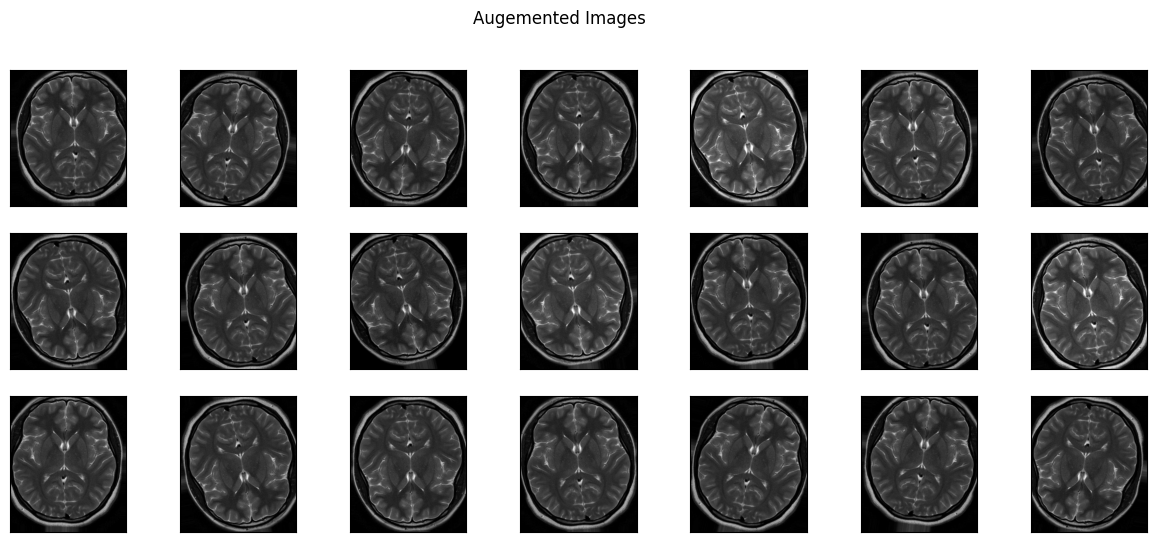

In [101]:
# نمایش تصویر اصلی قبل از اعمال تغییرات
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# نمایش تصاویر پس از اعمال تغییرات پیش‌پردازش
plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    # نمایش حداکثر ۳×۷ تصویر پس از اعمال تغییرات
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [ ]:
#!rm -rf preview/


In [102]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

# تعیین تولیدکننده‌های داده برای داده‌های آموزش و اعتبارسنجی
train_datagen = ImageDataGenerator(
    rotation_range=15,  # محدوده چرخش تصاویر
    width_shift_range=0.1,  # محدوده تغییر عرض تصاویر
    height_shift_range=0.1,  # محدوده تغییر ارتفاع تصاویر
    shear_range=0.1,  # مقدار شیری تصاویر
    brightness_range=[0.5, 1.5],  # محدوده روشنایی تصاویر
    horizontal_flip=True,  # چرخش افقی تصاویر به صورت تصادفی
    vertical_flip=True,  # چرخش عمودی تصاویر به صورت تصادفی
    preprocessing_function=preprocess_input  # پیش‌پردازش تصاویر
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # پیش‌پردازش تصاویر
)

# تولیدکننده داده برای داده‌های آموزش
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',  # حالت رنگی
    target_size=IMG_SIZE,  # اندازه مقصد تصاویر
    batch_size=32,  # اندازه دسته
    class_mode='binary',  # حالت کلاس بندی
    seed=RANDOM_SEED  # تنظیم داده تصادفی
)

# تولیدکننده داده برای داده‌های اعتبارسنجی
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',  # حالت رنگی
    target_size=IMG_SIZE,  # اندازه مقصد تصاویر
    batch_size=16,  # اندازه دسته
    class_mode='binary',  # حالت کلاس بندی
    seed=RANDOM_SEED  # تنظیم داده تصادفی
)


Found 253 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


In [103]:
# بارگذاری مدل پایه
vgg16_weight_path = '/content/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'  # مسیر وزن‌های مدل VGG16
base_model = VGG16(
    weights=vgg16_weight_path,  # بارگذاری وزن‌های مدل از فایل خارجی
    include_top=False,  # عدم اضافه کردن لایه‌های Fully Connected (Dense) بالای مدل
    input_shape=IMG_SIZE + (3,)  # شکل ورودی تصاویر به مدل (اندازه تصاویر با سه کانال رنگی)
)


In [104]:
NUM_CLASSES = 1  # تعداد کلاس‌ها

# تعریف مدل شبکه عصبی
model = Sequential()

# اضافه کردن مدل پایه (VGG16) به مدل اصلی
model.add(base_model)

# اضافه کردن لایه Flatten برای تبدیل خروجی مدل پایه به بردار یک بعدی
model.add(layers.Flatten())

# اضافه کردن لایه Dropout برای جلوگیری از بیش‌برازش
model.add(layers.Dropout(0.5))

# اضافه کردن لایه Dense با تابع فعال‌سازی sigmoid به عنوان لایه خروجی
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# غیرقابل آموزش کردن لایه‌های مدل پایه
model.layers[0].trainable = False

# تنظیمات مدل شبکه عصبی
model.compile(
    loss='binary_crossentropy',  # تابع هزینه: crossentropy دودویی
    optimizer=RMSprop(lr=1e-4),  # بهینه‌ساز: RMSprop با نرخ یادگیری ۱e-4
    metrics=['accuracy']  # معیار عملکرد: دقت
)

# نمایش اطلاعات مختصری از معماری مدل شبکه عصبی
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14739777 (56.23 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [105]:
EPOCHS = 2  # تعداد ایپاک‌ها
es = EarlyStopping(
    monitor='val_acc',  # متغیری که بر اساس آن عملکرد مدل بررسی می‌شود
    mode='max',  # حالت بررسی برای early stopping (بیشینه یا کمینه بودن مقدار متغیر)
    patience=6  # حداکثر تعداد ایپاک‌هایی که بدون بهبود عملکرد مدل می‌گذرد
)

# آموزش مدل با استفاده از داده‌های آموزش و اعتبارسنجی
history = model.fit_generator(
    train_generator,  # تولیدکننده داده‌های آموزش
    steps_per_epoch=10,  # تعداد گام‌ها در هر ایپاک
    epochs=EPOCHS,  # تعداد ایپاک‌ها
    validation_data=validation_generator,  # داده‌های اعتبارسنجی
    validation_steps=25,  # تعداد گام‌ها برای اعتبارسنجی در هر ایپاک
    callbacks=[es]  # لیستی از callback‌ها (در اینجا early stopping)
)


<ipython-input-105-e3380c9169fa>:8: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/2
 8/10 [=======================>......] - ETA: 38s - loss: 12.9402 - accuracy: 0.6324

10/10 [==============================] - 194s 19s/step - loss: 12.9402 - accuracy: 0.6324 - val_loss: 5.0045 - val_accuracy: 0.6818


In [106]:
# دریافت مقادیر دقت و خطا برای هر ایپاک از تاریخچه آموزش
acc = history.history['accuracy']  # دقت در داده‌های آموزش
loss = history.history['loss']  # خطا در داده‌های آموزش
val_acc = history.history['val_accuracy']  # دقت در داده‌های اعتبارسنجی
val_loss = history.history['val_loss']  # خطا در داده‌های اعتبارسنجی

# محدوده ایپاک‌ها برای نمایش در نمودار
epochs_range = range(1, len(history.epoch) + 1)


In [107]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


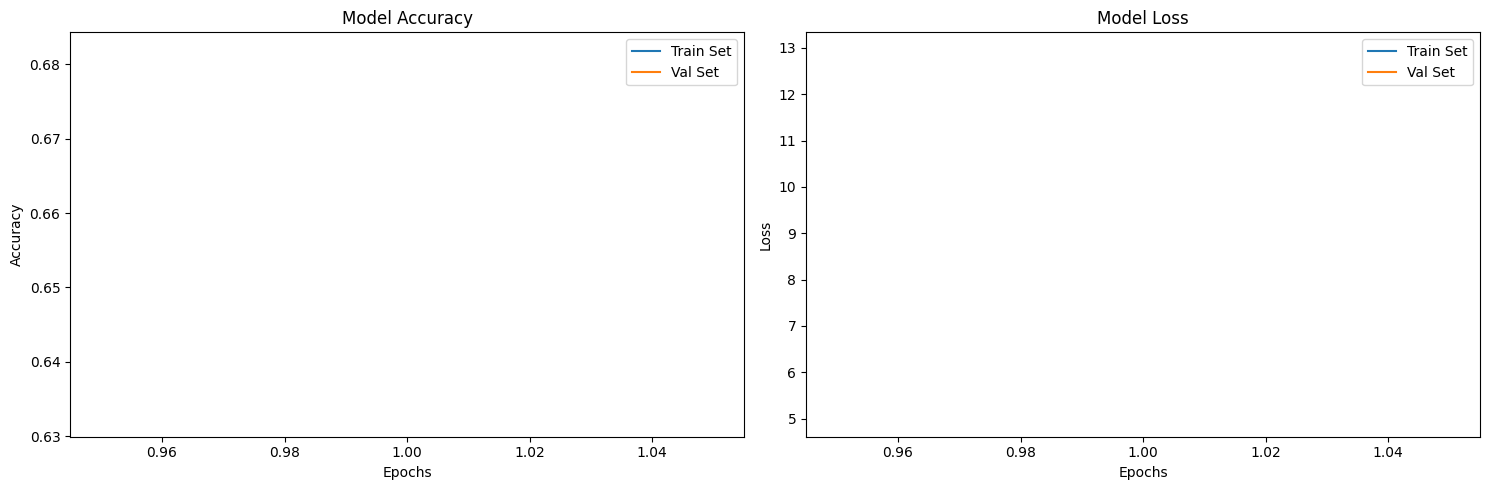

In [110]:
# نمایش عملکرد مدل در طول ایپاک‌ها
acc = history.history['accuracy']  # دقت در داده‌های آموزش
val_acc = history.history['val_accuracy']  # دقت در داده‌های اعتبارسنجی
loss = history.history['loss']  # خطا در داده‌های آموزش
val_loss = history.history['val_loss']  # خطا در داده‌های اعتبارسنجی
epochs_range = range(1, len(history.epoch) + 1)  # محدوده ایپاک‌ها برای نمایش در نمودار

# تنظیمات نمودار
plt.figure(figsize=(15,5))

# نمودار دقت مدل
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')  # خط دقت در داده‌های آموزش
plt.plot(epochs_range, val_acc, label='Val Set')  # خط دقت در داده‌های اعتبارسنجی
plt.legend(loc="best")  # نمایش علامت‌های توضیحی
plt.xlabel('Epochs')  # برچسب محور افقی
plt.ylabel('Accuracy')  # برچسب محور عمودی
plt.title('Model Accuracy')  # عنوان نمودار دقت

# نمودار خطا مدل
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')  # خط خطا در داده‌های آموزش
plt.plot(epochs_range, val_loss, label='Val Set')  # خط خطا در داده‌های اعتبارسنجی
plt.legend(loc="best")  # نمایش علامت‌های توضیحی
plt.xlabel('Epochs')  # برچسب محور افقی
plt.ylabel('Loss')  # برچسب محور عمودی
plt.title('Model Loss')  # عنوان نمودار خطا

plt.tight_layout()  # تنظیمات ظاهری نمودار
plt.show()  # نمایش نمودار


3/3 [==============================] - 39s 10s/step
Val Accuracy = 0.67


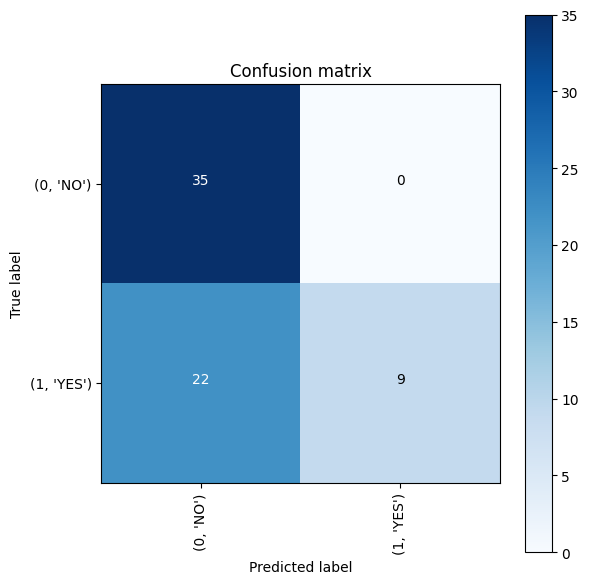

In [111]:
# پیش‌بینی و ارزیابی روی مجموعه داده اعتبارسنجی
predictions = model.predict(X_val_prep)  # پیش‌بینی برچسب‌ها بر روی داده‌های اعتبارسنجی
predictions = [1 if x > 0.5 else 0 for x in predictions]  # تبدیل احتمالات به برچسب‌های دو طرفه (۰ یا ۱)

# محاسبه دقت ارزیابی
accuracy = accuracy_score(y_val, predictions)  # محاسبه دقت ارزیابی
print('Val Accuracy = %.2f' % accuracy)  # چاپ دقت ارزیابی

# محاسبه و نمایش ماتریس درهم‌ریختگی
confusion_mtx = confusion_matrix(y_val, predictions)  # محاسبه ماتریس درهم‌ریختگی
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.items()), normalize=False)  # نمایش ماتریس درهم‌ریختگی


8/8 [==============================] - 146s 18s/step
Test Accuracy = 0.45


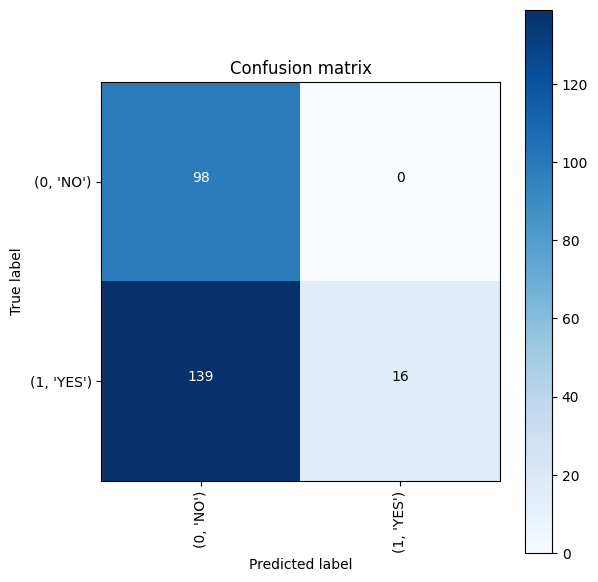

In [112]:
# پیش‌بینی و ارزیابی روی مجموعه داده آزمون
predictions = model.predict(X_test_prep)  # پیش‌بینی برچسب‌ها بر روی داده‌های آزمون
predictions = [1 if x > 0.5 else 0 for x in predictions]  # تبدیل احتمالات به برچسب‌های دو طرفه (۰ یا ۱)

# محاسبه دقت ارزیابی
accuracy = accuracy_score(y_test, predictions)  # محاسبه دقت ارزیابی
print('Test Accuracy = %.2f' % accuracy)  # چاپ دقت ارزیابی

# محاسبه و نمایش ماتریس درهم‌ریختگی
confusion_mtx = confusion_matrix(y_test, predictions)  # محاسبه ماتریس درهم‌ریختگی
cm = plot_confusion_matrix(confusion_mtx, classes=list(labels.items()), normalize=False)  # نمایش ماتریس درهم‌ریختگی


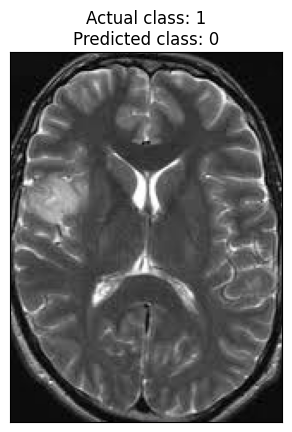

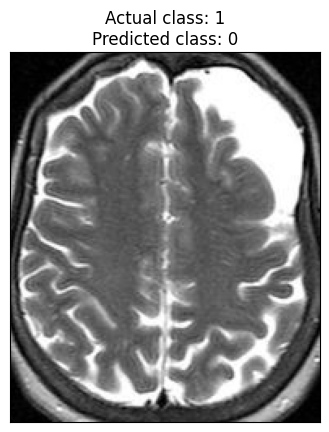

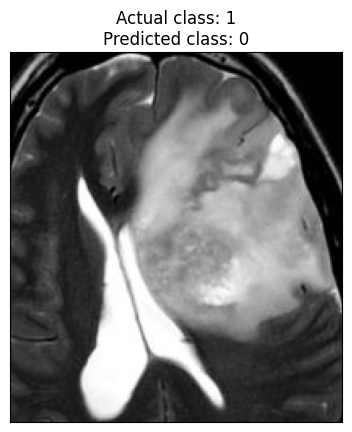

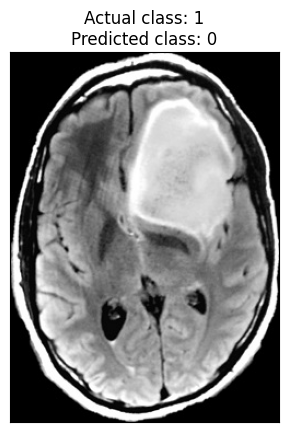

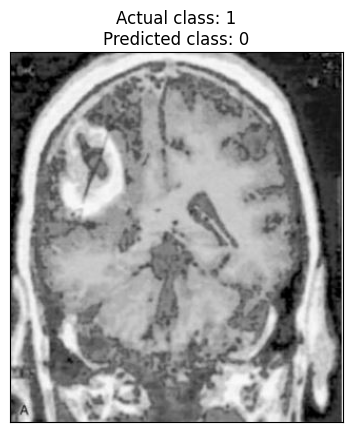

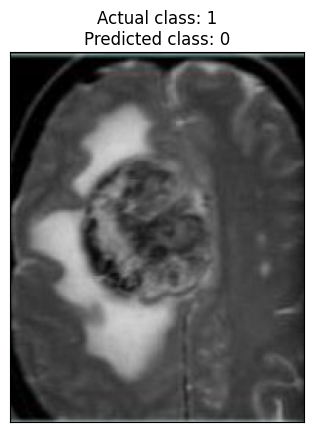

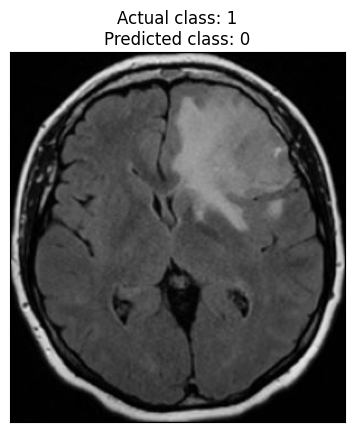

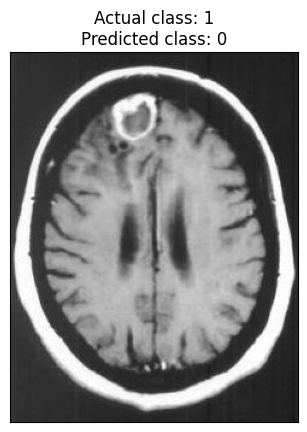

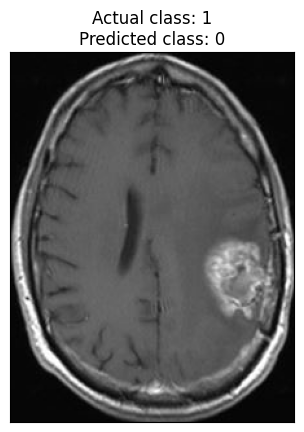

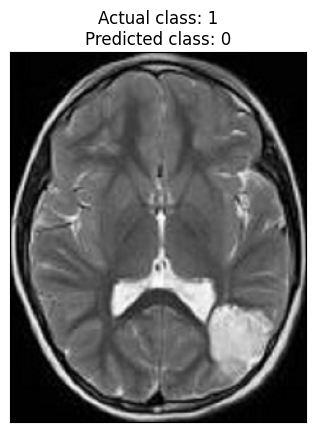

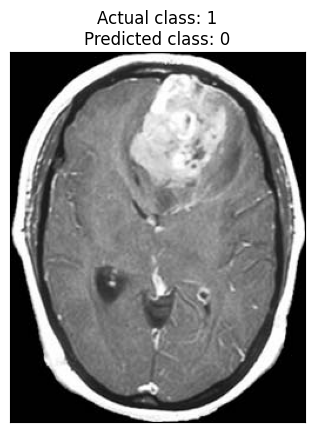

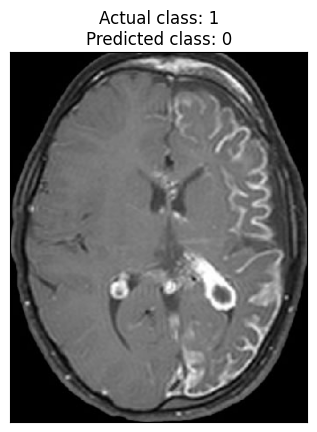

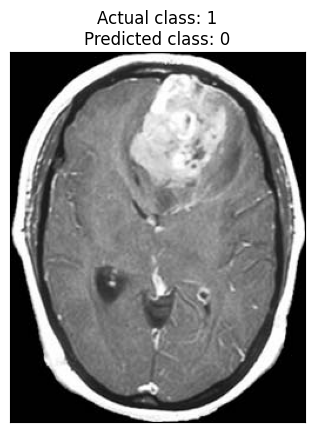

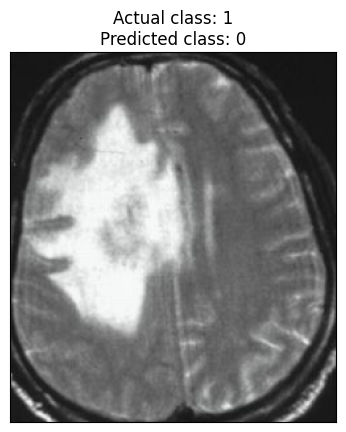

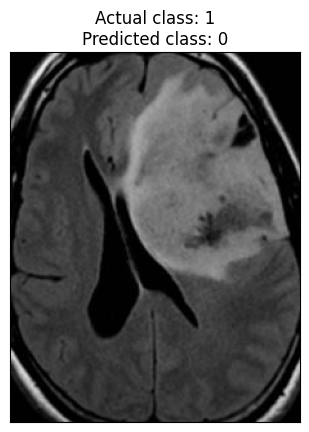

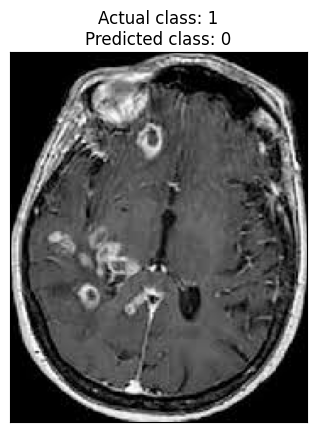

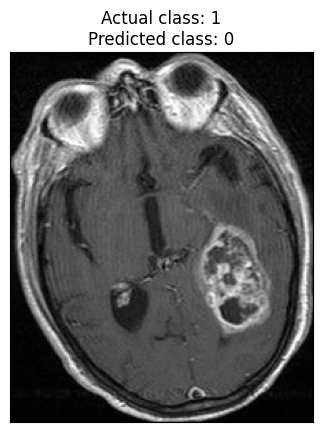

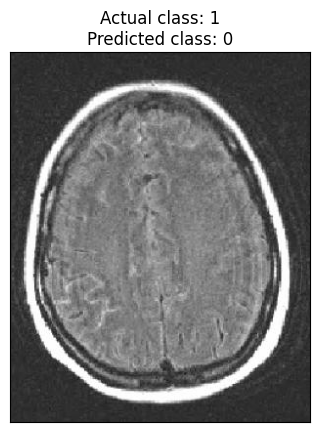

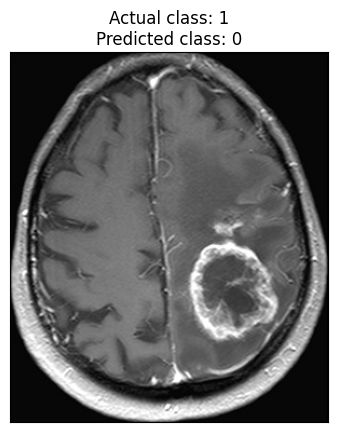

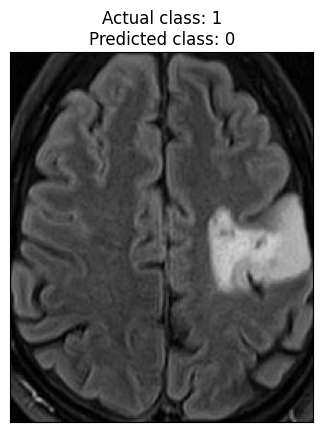

In [ ]:
# یافتن شاخص‌های تصاویری که اشتباه دسته‌بندی شده‌اند
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]

# اگر هیچ تصویری اشتباه دسته‌بندی نشده‌باشد
if ind_list.size == 0:
    print('There are no misclassified images.')
# در غیر این صورت
else:
    # نمایش تصاویر اشتباه دسته‌بندی شده‌با توضیحات
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])  # نمایش تصویر
        plt.xticks([])  # حذف خطوط شمارشی محور افقی
        plt.yticks([])  # حذف خطوط شمارشی محور عمودی
        plt.title(f'Actual class: {y_test[i]}\nPredicted class: {predictions[i]}')  # افزودن عنوان با برچسب دسته‌بندی‌ها
        plt.show()  # نمایش تصویر
